# Associating a cost with each action

In this notebook, I am going to be expanding on what I learned in the Breadth-First exercise. I'm going to figure out how to associate a cost to each action in the action set. I'll likely choose to associate a cost to each action corresponding to straight-line grid distance. I'll eventually add diagnoal actions to the action set, too. So they'll have a cost of sqrt2.

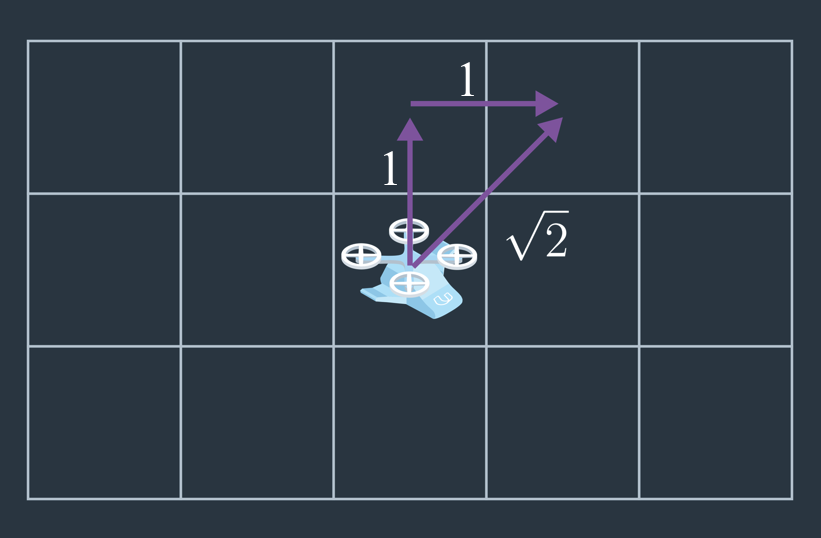
Source: Udacity

The way I'm going to implement these costs in my code is by modifying my Action class. Each action will not only contain information about how it translates the drone as before but will also now include cost information, too. 

In [1]:
from enum import Enum
class Action(Enum): 
    """
    Defines the action space and associated properties, cost and delta.
    """
    # The third tuple element is cost
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP: 
            return '^'
        elif self == self.DOWN:
            return 'v'
    
    # Return an action's cost with this property
    @property
    def cost(self):
        return self.value[2]
    # Return an action's delta
    @property
    def delta(self):
        return (self.value[0], self.value[1])


In [7]:
a = Action.LEFT
a.delta

(0, -1)

In [15]:
# Import numpy, Enum, and Queue
import numpy as np
from queue import Queue, PriorityQueue

# Define a start and goal location
start = (0, 0)
goal = (4, 4)
# Define a state space
grid = np.array([
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 0]
    ])

# Define a function that returns a list of valid actions
# through the grid from the current node
def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    # First defines a list of all possible actions
    valid = [Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT]
    n, m = grid.shape[0] - 1, grid.shape[1] -1
    x, y = current_node
    
    # Removes actions if they're found to be off grid
    if x - 1 < 0 or grid[x-1, y] == 1:
        valid.remove(Action.UP)
    if x + 1 > n or grid[x+1, y] == 1:
        valid.remove(Action.DOWN)
    if y - 1 < 0 or grid[x, y-1] == 1:
        valid.remove(Action.LEFT)
    if y + 1 > m or grid[x, y+1] == 1:
        valid.remove(Action.RIGHT)
    
    return valid

def visualize_path(grid, path, start):
    sgrid = np.zeros(np.shape(grid), dtype=str)
    sgrid[:] = ' '
    sgrid[grid[:] == 1] = 'O'
    
    pos = start
    
    for a in path:
        da = a.value
        sgrid[pos[0], pos[1]] = str(a)
        pos = (pos[0] + da[0], pos[1] + da[1])
    sgrid[pos[0], pos[1]] = 'G'
    sgrid[start[0], start[1]] = 'S'  
    return sgrid

def uniform_cost(grid, start, goal):
    """
    Given a 2d grid, a start cell, and a goal cell, executes uniform cost search.
    If the goal has been found, returns a list called path containing the path and 
    the total cost.
    """
    # First initializes queue for candidate
    # nodes, set for visited nodes, dictionary
    # to trace path, and boolean found to
    # track whether goal has been located.
    
    q = PriorityQueue()
    q.put((0, start))
    visited = set(start)
    branch = {}
    found = False
    
    # Next, Uniform Cost Search begins. Starting from the goal
    # cell, the search algorithm explores neighboring
    # locations, making sure only to consider free, 
    # unvisited grid space. Each time the algorithm
    # finds such a location, it'll add the corresponding
    # grid location to a queue to be futher explored, mark 
    # the cell as visited, and record path information in the
    # branch dictionary.
    
    while not q.empty():
        item = q.get()
        current_cost = item[0]
        current_node = item[1]
        
        if current_node == goal:
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                da = action.delta
                cost = action.cost
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                new_cost = current_cost + cost
                if next_node not in visited:
                    visited.add(next_node)
                    q.put(new_cost, next_node)
                    branch[next_node] = (new_cost, current_node, action)
    path = []
    path_cost = 0
    if found:
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][2])
            path_cost += branch[n][0]
            n = branch[n][1]
        path.append(branch[n][2])
    
    return path[::-1], path_cost
                

If all actions have uniform cost, then it doesn't seem like we need another data structure besides Python's Queue to hold candidate nodes. But I imagine if we want to start assigning costs that are not all the same, then we would need some way to only set next_node to the queue if it is the lowest cost node. That's my hypothesis.

Upon doing some research, I am learning about Python's built in PriorityQueue. Basically, items are prioritized. The get command will remove and return the highest priority item. The data structure's default behavior is good enough for this application because it'll automatically dequeue candidate nodes with the lowest cost first. So, I can now go back to my code and add diagnonal translations if I want, and I should get the behavior that I would expect from a lowest cost search. 

In [16]:
path, path_cost = uniform_cost(grid, start, goal)
print(path_cost, path)

Found a path.
14 [<Action.DOWN: (1, 0, 1)>, <Action.DOWN: (1, 0, 1)>, <Action.DOWN: (1, 0, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.UP: (-1, 0, 1)>, <Action.UP: (-1, 0, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.DOWN: (1, 0, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.DOWN: (1, 0, 1)>, <Action.DOWN: (1, 0, 1)>, <Action.LEFT: (0, -1, 1)>]


In [14]:
visualize_path(grid, path, start)

array([['S', 'O', ' ', ' ', ' ', ' '],
       ['v', 'O', '>', '>', 'v', ' '],
       ['v', 'O', '^', 'O', '>', 'v'],
       ['>', '>', '^', 'O', 'O', 'v'],
       [' ', ' ', ' ', 'O', 'G', '<']], dtype='<U1')